In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy.stats import chi2_contingency
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/qianfu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/qianfu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('processced text.csv')
df.head()

,type_of_material,news_desk,section_name,author,preprocessed_text
0,News,Lifestyle & Leisure,Home & Garden,Penelope Green,point view prescriptive descriptive definite...
1,News,Lifestyle & Leisure,Home & Garden,Marianne Rohrlich,ten highend design gallery offer percent m...
2,News,Business,Business Day,Lauren Laughlin,banker may suffer decline dealmaking also take...
3,News,National,U.S.,Damien Cave,florida scale back purchase sugar company land...
4,News,Business,Technology,Bloomberg News,taketwo interactive maker grand theft auto acc...


In [3]:
print(df.loc[4, "preprocessed_text"])

taketwo interactive maker grand theft auto accuse backdate option historically low price scheme reward key employee taketwo interactive software maker grand theft auto video game agree pay   million settle lawsuit security exchange commission accuse company backdate stock option video game maker pay   million settle stock option case suit litigation taketwo interactive software inc stock option purchase plan security commodity violation


### "Best Model" used on the newly preprocessed data

In [4]:
#remove common words
#list of common words to remove
common_words_to_remove = ["new", "york", "year", "city"]

# define a function to remove those words from "preprocessed_text" feature
def remove_common_words(text, words_to_remove):
    tokens = text.split()  
    filtered_tokens = [token for token in tokens if token not in words_to_remove]
    return ' '.join(filtered_tokens)  

df['preprocessed_text'] = df['preprocessed_text'].apply(lambda text: remove_common_words(text, common_words_to_remove))


In [5]:
#vectorized the newly preprocessed data

tfidf_vect = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)

# apply it to preprocessed text
tfidf_matrix = tfidf_vect.fit_transform(df['preprocessed_text'])

In [6]:

df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: x.split())
texts = df['preprocessed_text'].tolist()
# create a gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

In [7]:
feature_names = tfidf_vect.get_feature_names_out()

In [8]:
#Set random state
random_state = 696

In [9]:
with open('out/best_model.pkl', 'rb') as g:
    best_model = pickle.load(g)

In [10]:
W = best_model.fit_transform(tfidf_matrix)
H = best_model.components_

In [11]:
#calculate the coherence score.
num_top_words = 50
topics = []

for topic_idx, topic in enumerate(H):
    top_features_ind = topic.argsort()[-num_top_words:][::-1]
    top_features = [feature_names[i] for i in top_features_ind]
    topics.append(top_features)


coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

In [12]:
coherence_score

0.7134210174067102

In [13]:
#get the top 50 words of each topic
num_top_words = 100

for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx + 1}:")
    top_features_ind = topic.argsort()[-num_top_words:][::-1]  
    top_features = [feature_names[i] for i in top_features_ind]
    top_features_str = ", ".join(top_features)
    print(top_features_str)

Topic 1:
book, day, say, one, time, make, people, get, police, not, woman, first, life, like, two, world, home, man, die, movie, quotation, school, college, show, week, game, go, last, take, university, good, television, tv, play, work, state, puzzle, know, black, find, death, come, literature, season, child, team, program, three, long, murder, night, back, inc, way, football, art, may, music, company, look, many, basketball, ny, run, family, could, national, would, live, story, right, open, baseball, start, use, see, well, nyc, coronavirus, high, help, even, park, service, month, theater, young, friday, want, around, news, manhattan, become, give, league, girl, correction, sport, sunday, health
Topic 2:
marry, wedding, engagement, couple, officiate, bride, meet, saturday, rev, minister, ceremony, church, dr, rabbi, groom, perform, event, priest, friend, universal, ny, evening, daughter, catholic, space, son, michael, st, roman, life, university, date, john, elizabeth, marriage, david,

### Descriptive label for each topic and article-topic distribution

Topic 1: Cultural, Social, and Urban Life

Topic 2: Personal Events and Ceremonies

Topic 3: Politics, Governance, and International Affairs

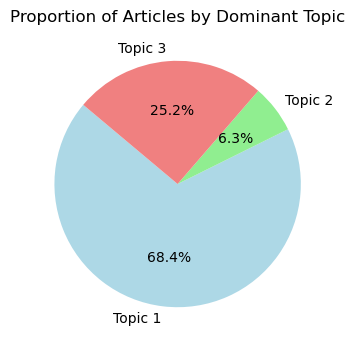

In [14]:
# Determine the dominant topic for each article
dominant_topic = np.argmax(W, axis=1)

# Count the number of articles associated with each topic
topic_counts = np.bincount(dominant_topic)

plt.figure(figsize=(4, 4))
plt.pie(topic_counts, labels=['Topic 1', 'Topic 2', 'Topic 3'], autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Proportion of Articles by Dominant Topic')
plt.show()


### Assigning the topic label to each article

In [15]:

# add topic label column
df['topic_label'] = dominant_topic

topic_names = {0: 'Lifestyle', 1: 'Events', 2: 'Politics'}

df['topic_label'] = df['topic_label'].map(topic_names)


In [16]:
df.head()

,type_of_material,news_desk,section_name,author,preprocessed_text,topic_label
0,News,Lifestyle & Leisure,Home & Garden,Penelope Green,"[point, view, prescriptive, descriptive, defin...",Lifestyle
1,News,Lifestyle & Leisure,Home & Garden,Marianne Rohrlich,"[ten, highend, design, gallery, offer, percent...",Lifestyle
2,News,Business,Business Day,Lauren Laughlin,"[banker, may, suffer, decline, dealmaking, als...",Lifestyle
3,News,National,U.S.,Damien Cave,"[florida, scale, back, purchase, sugar, compan...",Politics
4,News,Business,Technology,Bloomberg News,"[taketwo, interactive, maker, grand, theft, au...",Lifestyle


## Examine the predictors

### Correlation Analysis
perform a chi-square test of independence to see if there is a significant association between each of these predictors and the topic_label.

The Chi-square test will help us understand whether the distribution of topic labels is independent of these categorical variables or if there's a significant association between them.

In [17]:


# Convert to num
df['type_of_material_num'] = df['type_of_material'].astype('category').cat.codes
df['news_desk_num'] = df['news_desk'].astype('category').cat.codes
df['section_name_num'] = df['section_name'].astype('category').cat.codes
df['author_num'] = df['author'].astype('category').cat.codes

# perform chi-square test for each feature against 'topic_label'
features = ['type_of_material_num', 'news_desk_num', 'section_name_num', 'author_num']
for feature in features:
    contingency_table = pd.crosstab(df[feature], df['topic_label'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {feature} vs topic_label:")
    print(f"Chi-square statistic: {chi2}, p-value: {p}\n")


Chi-square test for type_of_material_num vs topic_label:
Chi-square statistic: 796.5336424839109, p-value: 2.3675722744860165e-141

Chi-square test for news_desk_num vs topic_label:
Chi-square statistic: 7765.8569598417, p-value: 0.0

Chi-square test for section_name_num vs topic_label:
Chi-square statistic: 7021.916707084455, p-value: 0.0

Chi-square test for author_num vs topic_label:
Chi-square statistic: 6539.128530937398, p-value: 1.1392150220797322e-119



### Interpreting the result

all four features (type_of_material, news_desk, section_name, author) show a statistically significant association with the topic_label. This means these features could potentially be useful predictors in our topic classification task. Their inclusion could improve the model's ability to accurately predict the topic of an article.

### To avoid high dimentionality in the models

In [18]:
print("Value Counts for 'type_of_material':")
print(df['type_of_material'].value_counts())

print("\nValue Counts for 'news_desk':")
print(df['news_desk'].value_counts())

print("\nValue Counts for 'section_name':")
print(df['section_name'].value_counts())

print("\nValue Counts for 'author':")
print(df['author'].value_counts())


Value Counts for 'type_of_material':
type_of_material
News               5235
Op-Ed               440
Review              284
Editorial           197
Letter              174
Obituary (Obit)     153
Quote                91
briefing             91
Brief                85
Correction           83
List                 78
Schedule             75
News Analysis        45
Question             16
Text                  5
Series                3
Biography             3
recipe                2
Interview             2
First Chapter         1
Newsletter            1
Name: count, dtype: int64

Value Counts for 'news_desk':
news_desk
Foreign                749
Metro                  715
Sports                 709
Business               669
National               668
Opinion & Editorial    664
Arts & Culture         357
Society                355
Lifestyle & Leisure    184
Style & Fashion        175
BookReview             170
Washington             169
Letters                161
Summary                1

### Dimensionality Reduction Strategy:

Based on the distribution of each feature, identifying the top n categories for each feature based on their frequency and then grouping the less frequent categories into an "Other" category. 

Top 20 authors
Top 10 news desks
Top 10 section names



In [19]:

top_authors = df['author'].value_counts().nlargest(20).index
top_news_desks = df['news_desk'].value_counts().nlargest(10).index
top_section_names = df['section_name'].value_counts().nlargest(10).index

# group other categories into 'Other'
df['author_reduced'] = df['author'].apply(lambda x: 'Other' if x not in top_authors else x)
df['news_desk_reduced'] = df['news_desk'].apply(lambda x: 'Other' if x not in top_news_desks else x)
df['section_name_reduced'] = df['section_name'].apply(lambda x: 'Other' if x not in top_section_names else x)


In [20]:
df.head()

,type_of_material,news_desk,section_name,author,preprocessed_text,topic_label,type_of_material_num,news_desk_num,section_name_num,author_num,author_reduced,news_desk_reduced,section_name_reduced
0,News,Lifestyle & Leisure,Home & Garden,Penelope Green,"[point, view, prescriptive, descriptive, defin...",Lifestyle,8,15,16,1553,Other,Lifestyle & Leisure,Other
1,News,Lifestyle & Leisure,Home & Garden,Marianne Rohrlich,"[ten, highend, design, gallery, offer, percent...",Lifestyle,8,15,16,1274,Other,Lifestyle & Leisure,Other
2,News,Business,Business Day,Lauren Laughlin,"[banker, may, suffer, decline, dealmaking, als...",Lifestyle,8,4,7,1176,Other,Business,Business Day
3,News,National,U.S.,Damien Cave,"[florida, scale, back, purchase, sugar, compan...",Politics,8,20,44,420,Other,National,U.S.
4,News,Business,Technology,Bloomberg News,"[taketwo, interactive, maker, grand, theft, au...",Lifestyle,8,4,36,249,Other,Business,Other


In [21]:
# drop no longer needed columns
df_model = df.drop(['news_desk', 'section_name', 'author', 
                    'type_of_material_num', 'news_desk_num', 'section_name_num', 'author_num'], axis=1)



In [22]:
df_model.head()

,type_of_material,preprocessed_text,topic_label,author_reduced,news_desk_reduced,section_name_reduced
0,News,"[point, view, prescriptive, descriptive, defin...",Lifestyle,Other,Lifestyle & Leisure,Other
1,News,"[ten, highend, design, gallery, offer, percent...",Lifestyle,Other,Lifestyle & Leisure,Other
2,News,"[banker, may, suffer, decline, dealmaking, als...",Lifestyle,Other,Business,Business Day
3,News,"[florida, scale, back, purchase, sugar, compan...",Politics,Other,National,U.S.
4,News,"[taketwo, interactive, maker, grand, theft, au...",Lifestyle,Other,Business,Other


## Getting df ready for ML

In [23]:
# one-hot encoding
df_encoded = pd.get_dummies(df_model, columns=['type_of_material', 'author_reduced', 'news_desk_reduced', 'section_name_reduced'])


In [24]:
# Vectorize preprocessed_text

# convert list of words in 'preprocessed_text' to a string
df_encoded['preprocessed_text'] = df_encoded['preprocessed_text'].apply(lambda x: ' '.join(x))


tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000) 

# Fit and transform 'preprocessed_text' to obtain TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(df_encoded['preprocessed_text'])


In [25]:
# combine tfid_matrix with encoded features

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# drop 'preprocessed_text' 
df_encoded.drop('preprocessed_text', axis=1, inplace=True)


df_final = pd.concat([df_encoded.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)


#### Now, the df_final is the one used for topic classification models, containing both the vectorized preprocessed_text predictor and one-hot encoded other predictors. 

In [26]:
df_final.head()

,topic_label,type_of_material_Biography,type_of_material_Brief,type_of_material_Correction,type_of_material_Editorial,type_of_material_First Chapter,type_of_material_Interview,type_of_material_Letter,type_of_material_List,type_of_material_News,...,world,would,write,writer,writing,yankee,yankees,yearold,yet,young
0,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Politics,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159553,0.0
4,Lifestyle,False,False,False,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [27]:
with open('out/df_final.pkl', 'wb') as f:
    pickle.dump(df_final, f)